<a href="https://colab.research.google.com/github/cancan-lab/Notebook-DM2/blob/main/164221112_Rayya_Andina_Nathania_Tugas_Image_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1) Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

from tensorflow.keras.datasets import mnist

np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", 50)

In [ ]:
def clustering_accuracy_with_hungarian(y_true, y_pred):
    labels_true = np.unique(y_true)
    labels_pred = np.unique(y_pred)
    n_true = labels_true.size
    n_pred = labels_pred.size
    n = max(n_true, n_pred)
    cost = np.zeros((n, n), dtype=np.int64)

    for i, t in enumerate(labels_true):
        mask_t = (y_true == t)
        for j, p in enumerate(labels_pred):
            cost[i, j] = -np.sum(y_pred[mask_t] == p)  # negative for max matching

    if n_true < n:
        cost[n_true:, :] = 0
    if n_pred < n:
        cost[:, n_pred:] = 0

    row_ind, col_ind = linear_sum_assignment(cost)
    total_matches = -cost[row_ind, col_ind].sum()
    return total_matches / y_true.size

# **2) LOAD MNIST**

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Train shape:", X_train.shape, y_train.shape)
print("Test  shape:", X_test.shape, y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (60000, 28, 28) (60000,)
Test  shape: (10000, 28, 28) (10000,)


In [ ]:
# Gabungkan train+test untuk clustering
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)
print("All   shape:", X_all.shape, y_all.shape)


All   shape: (70000, 28, 28) (70000,)


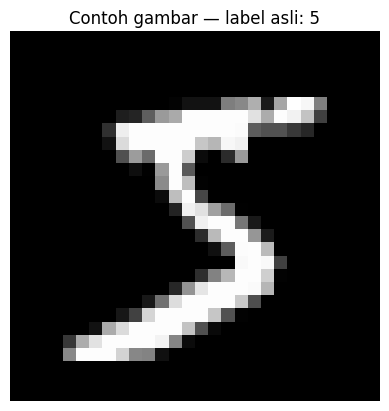

In [ ]:
plt.figure()
plt.imshow(X_train[0], cmap="gray")
plt.title(f"Contoh gambar — label asli: {y_train[0]}")
plt.axis("off")
plt.show()

# **3) PREPROCESSING**

## **3.1 Normalisasi**

In [ ]:
X_all = X_all.astype("float32") / 255.0

## **3.2 Flatten 28x28**

In [ ]:
n_samples = X_all.shape[0]
X_flat = X_all.reshape(n_samples, -1)

## **3.3 Standardisasi**

In [ ]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_flat)

## **3.4 PCA**

In [ ]:
pca = PCA(n_components=0.95, svd_solver="full", random_state=42)
X_pca = pca.fit_transform(X_std)

## **3.5 Ringkasan Preprocessing**

In [ ]:
print("=== Ringkasan Preprocessing ===")
print("X_flat shape:", X_flat.shape)
print("X_std  shape:", X_std.shape)
print("X_pca  shape:", X_pca.shape)
print("PCA explained variance ratio sum:", pca.explained_variance_ratio_.sum())

=== Ringkasan Preprocessing ===
X_flat shape: (70000, 784)
X_std  shape: (70000, 784)
X_pca  shape: (70000, 332)
PCA explained variance ratio sum: 0.9500312


# **4) CLUSTERING**

In [ ]:
n_clusters = 10

## **KMeans**

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

## **Agglomerative**

In [ ]:
# agg = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
# agg_labels = agg.fit_predict(X_pca)

In [ ]:
print("Done clustering.")

Done clustering.


# **5) EVALUASI**

In [ ]:
def eval_clustering(name, labels):
    sil = silhouette_score(X_pca, labels, metric="euclidean")
    ari = adjusted_rand_score(y_all, labels)
    nmi = normalized_mutual_info_score(y_all, labels)
    acc = clustering_accuracy_with_hungarian(y_all, labels)
    return {
        "Algorithm": name,
        "Silhouette": sil,
        "ARI": ari,
        "NMI": nmi,
        "Hungarian Acc.": acc
    }

results = []
results.append(eval_clustering("KMeans", kmeans_labels))
# results.append(eval_clustering("Agglomerative (Ward)", agg_labels))

In [ ]:
df_results = pd.DataFrame(results)
display(df_results)

,Algorithm,Silhouette,ARI,NMI,Hungarian Acc.
0,KMeans,0.014286,0.317076,0.427754,0.4867


# **6) VISUALISASI**

## **6.1 PCA 2D scatter**

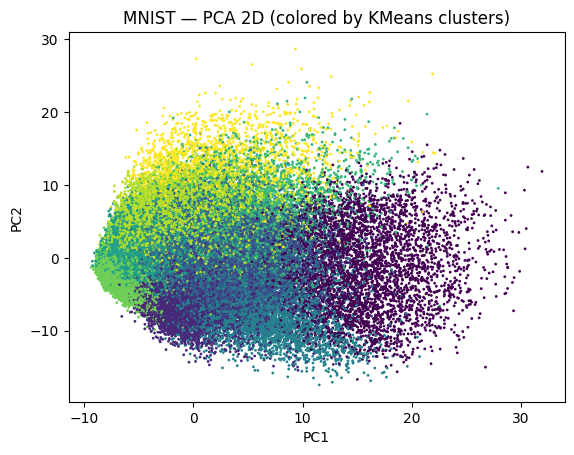

In [ ]:
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_std)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=1, c=kmeans_labels)
plt.title("MNIST — PCA 2D (colored by KMeans clusters)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## **6.2 Grid gambar per klaster (KMeans)**

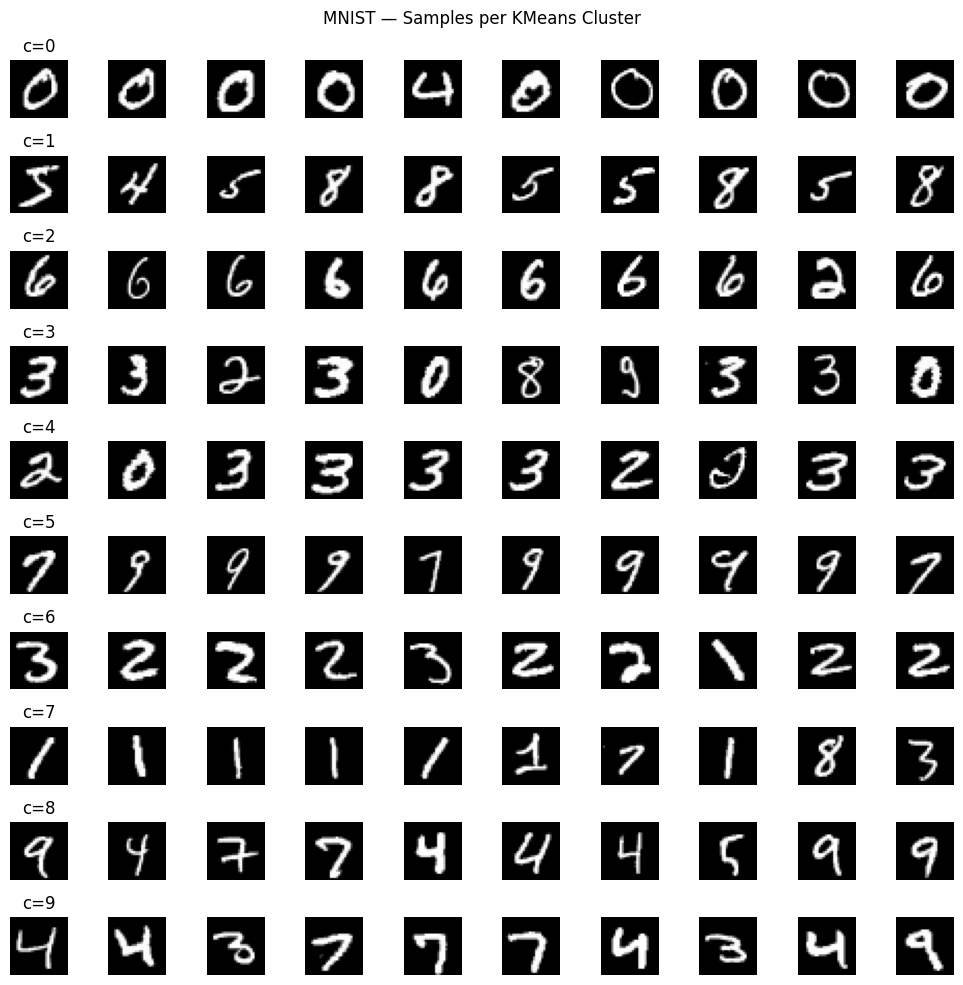

In [ ]:
def plot_image_grid(images, labels, max_per_cluster=10, title="MNIST per KMeans cluster"):
    unique = np.unique(labels)
    nclusters = unique.size
    ncols = max_per_cluster
    nrows = nclusters
    plt.figure(figsize=(ncols, nrows))
    for row, c in enumerate(unique):
        idxs = np.where(labels == c)[0][:max_per_cluster]
        for col, idx in enumerate(idxs):
            ax = plt.subplot(nrows, ncols, row*ncols + col + 1)
            ax.imshow(images[idx], cmap="gray")
            ax.set_axis_off()
            if col == 0:
                ax.set_title(f"c={int(c)}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_image_grid(X_all.reshape(-1, 28, 28), kmeans_labels, max_per_cluster=10,
                title="MNIST — Samples per KMeans Cluster")